In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input ,SpatialDropout3D,Dropout
import keras
from math import e
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from keras.models import load_model

In [2]:
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

In [4]:
#Surface data
t2mData = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/tasNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
rhData  = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/hursNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
u10Data = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/uasNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
v10Data = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/vasNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')


In [6]:
# Level Data
tLevData = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/taNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
zLevData = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/zgNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
wLevData = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/wapNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
uLevData = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/uaNHRegrid_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')

In [5]:
# Calculate wind speed and relative humidity inv  ushear
ws = ((v10Data.vas.values**2)+(u10Data.uas.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)},
                   coords={'time': v10Data.time,'latitude': v10Data.latitude,'longitude': v10Data.longitude})

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rhData.hurs)},
                   coords={'time': v10Data.time,'latitude': v10Data.latitude,'longitude': v10Data.longitude})



In [7]:
#Calculate inv
inv=t2mData.tas.values-tLevData.ta.sel(plev=85000).values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10Data.time,'latitude': v10Data.latitude,'longitude': v10Data.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

#u shear calculation
ushear=(uLevData.ua.sel(plev=85000).values-u10Data.uas.values)/(zLevData.zg.sel(plev=85000).values) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10Data.time,'latitude': v10Data.latitude,'longitude': v10Data.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [10]:
# AO data
AOData = xr.open_dataset('AWI-ESM-1-1-LR-AOindex-NDJF-Daily-1980-2014.nc')
aoTS=AOData.AO
Darray=np.zeros((AOData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(aoTS.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), aoTS[t].values)
AOData=xr.Dataset({'AO': (('time','latitude','longitude'), Darray)},
                  coords={'time': AOData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude}) 
# EU data
EUData = xr.open_dataset('AWI-ESM-1-1-LR-EUindex-NDJF-Daily-1980-2014.nc')
EUData.EU
euTS=EUData.EU
Darray=np.zeros((EUData.time.shape[0],t2mData.latitude.shape[0], t2mData.longitude.shape[0]))
for t in range(euTS.time.shape[0]) :
    Darray[t,:,:]=np.full((t2mData.latitude.shape[0], t2mData.longitude.shape[0]), euTS[t].values)
EUData=xr.Dataset({'EU': (('time','latitude','longitude'), Darray)},
                  coords={'time': EUData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})

In [11]:
# create mask
oro = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100))
oro.values = OroData.z.sel(latitude=slice(35,0),longitude=slice(50,100)).values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values

In [12]:
#AO
AO5D=AOData.AO.rolling(time=5).mean()

AO5DAll=AO5D[((AO5D.time.dt.month>11) | (AO5D.time.dt.month<2)) & 
             (AO5D.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),
                                           longitude=slice(50,100))

#EU
EU5D=EUData.EU.rolling(time=5).mean()

EU5DAll=EU5D[((EU5D.time.dt.month>11) | (EU5D.time.dt.month<2)) & 
             (EU5D.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),
                                           longitude=slice(50,100))

In [13]:
t1=AO5DAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
AO5DAll.values=t1.unstack()

t1=EU5DAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
EU5DAll.values=t1.unstack()

AO5DAll.values=AO5DAll.values*mask
AO5DAll.values=xr.where(np.isnan(AO5DAll.values),  0.000000000001,AO5DAll.values)

EU5DAll.values=EU5DAll.values*mask
EU5DAll.values=xr.where(np.isnan(EU5DAll.values),  0.000000000001,EU5DAll.values)

In [14]:
t2m=t2mData.tas.shift(time=1)
ws=ws_ds.ws.shift(time=1)
rh=rh_ds.rh.shift(time=1)
inv=inv_ds.inv.shift(time=1)
w=wLevData.wap.sel(plev=70000).shift(time=1)
ushear=ushear_ds.ushear.shift(time=1)

In [15]:
t2mTsAll=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wsTsAll=ws[((ws.time.dt.month>11) | (ws.time.dt.month<2)) & (ws.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTsAll=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
invTsAll=inv[((inv.time.dt.month>11) | (inv.time.dt.month<2)) & (inv.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
ushearTsAll=ushear[((ushear.time.dt.month>11) | (ushear.time.dt.month<2)) & (ushear.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
wTsAll=w[((w.time.dt.month>11) | (w.time.dt.month<2)) & (w.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [16]:
t1=t2mTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
t2mTsAll.values=t1.unstack()

t1=wsTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wsTsAll.values=t1.unstack()

t1=rhTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
rhTsAll.values=t1.unstack()

t1=invTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
invTsAll.values=t1.unstack()

t1=ushearTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
ushearTsAll.values=t1.unstack()


t1=wTsAll.stack(z=("latitude", "longitude"))
# fit scaler on training data
norm = StandardScaler().fit(t1)
# transform training data
t1.values = norm.transform(t1)
wTsAll.values=t1.unstack()

In [17]:
t2mTsAll.values=t2mTsAll.values*mask
wsTsAll.values=wsTsAll.values*mask
rhTsAll.values=rhTsAll.values*mask
invTsAll.values=invTsAll.values*mask
ushearTsAll.values=ushearTsAll.values*mask
wTsAll.values=wTsAll.values*mask


In [18]:
t2mTsAll.values=xr.where(np.isnan(t2mTsAll.values),  0.000000000001,t2mTsAll.values)
wsTsAll.values=xr.where(np.isnan(wsTsAll.values),  0.000000000001,wsTsAll.values)
rhTsAll.values=xr.where(np.isnan(rhTsAll.values),  0.000000000001,rhTsAll.values)
invTsAll.values=xr.where(np.isnan(invTsAll.values),  0.000000000001,invTsAll.values)
ushearTsAll.values=xr.where(np.isnan(ushearTsAll.values),  0.000000000001,ushearTsAll.values)
wTsAll.values=xr.where(np.isnan(wTsAll.values),  0.000000000001,wTsAll.values)


In [19]:
t2mt=t2mTsAll.values
t2mt=t2mt[:,:,:,None]
t2mt.shape


wst=wsTsAll.values
wst=wst[:,:,:,None]
wst.shape

rht=rhTsAll.values
rht=rht[:,:,:,None]
rht.shape


invt=invTsAll.values
invt=invt[:,:,:,None]
invt.shape

wt=wTsAll.values
wt=wt[:,:,:,None]
wt.shape

usheart=ushearTsAll.values
usheart=usheart[:,:,:,None]
usheart.shape

aot=AO5DAll.values
aot=aot[:,:,:,None]
aot.shape

eut=EU5DAll.values
eut=eut[:,:,:,None]
eut.shape


(2170, 18, 26, 1)

In [20]:
X=np.array([t2mt,rht,wst,invt,wt,usheart,aot,eut])
X.shape

(8, 2170, 18, 26, 1)

In [21]:
X_reshape = np.einsum('lkija->klija',X)
X_reshape.shape

(2170, 8, 18, 26, 1)

In [22]:
# Load saved model
# load model
model = load_model('../../Feb2021/Final_Models/AO_EU_SST_included/modelCNN.h5')
# summarize model.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 8, 18, 26, 16)     448       
_________________________________________________________________
average_pooling3d_6 (Average (None, 4, 9, 13, 16)      0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 4, 9, 13, 32)      13856     
_________________________________________________________________
average_pooling3d_7 (Average (None, 2, 5, 7, 32)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 5, 7, 32)       0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 2, 5, 7, 64)       55360     
_________________________________________________________________
average_pooling3d_8 (Average (None, 1, 3, 4, 64)      

In [23]:
yLR=model.predict(X_reshape)
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR[:,0])}, coords={'time':t2mTsAll.time.values})

In [24]:
yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)
print(yLRnf.yLR.shape[0])

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>=0.04,drop=True)
yLRintf=yLRint1.where(yLRint1<=0.44,drop=True)
print(yLRintf.yLR.shape[0])

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>0.44,drop=True)
print(yLRWd.yLR.shape[0])

21
1796
353


In [25]:
# Load X and y values
obs = load('../../Feb2021/Final_Models/AO_EU_SST_included/piedataObs.joblib') 
CNN=load('../../Feb2021/Final_Models/AO_EU_SST_included/piedataCNN.joblib')

Text(0.5, 1.0, 'Obs')

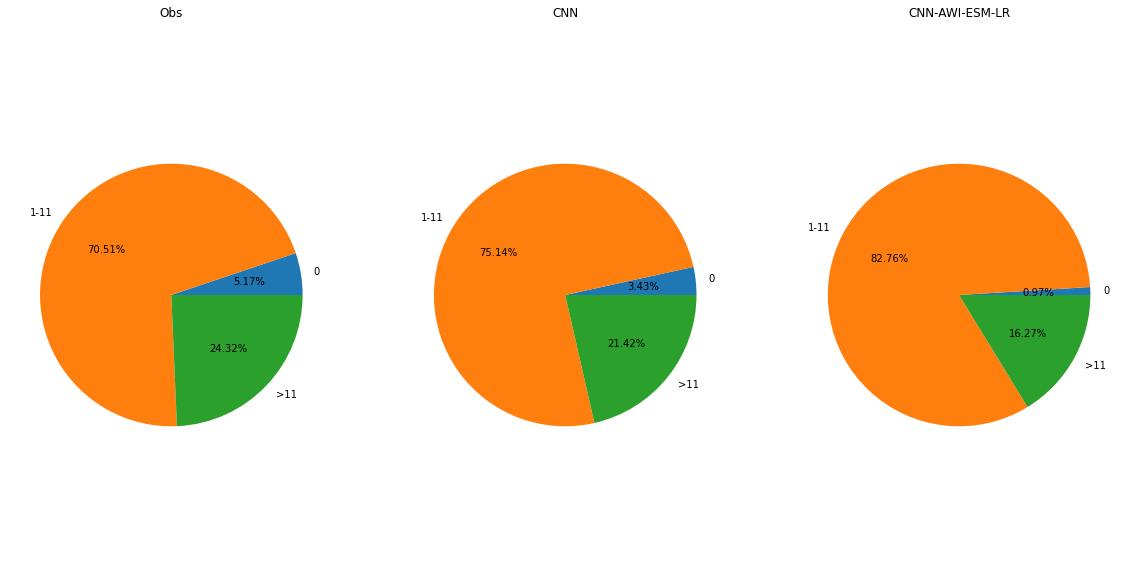

In [26]:
# Plot

fig = plt.figure(figsize=(20,10))
pieLabs = ['0', '1-11', '>11']
ax = fig.add_subplot(132)
ax.axis('equal')
ax.pie(CNN, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('CNN')

ax1 = fig.add_subplot(133)
ax1.axis('equal')
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('CNN-AWI-ESM-LR')

ax2 = fig.add_subplot(131)
ax2.axis('equal')
ax2.pie(obs, labels = pieLabs,autopct='%1.2f%%')
ax2.set_title('Obs')
